In [86]:
import numpy as np
import math
import time
import pygame

class Body:
    #`Gravitational` constant.Can be the real value or free choice
    G = 0.002
    
    signal_speed = 10
    def __init__(self, x,y,mass,radius = 0.2,color=(250,250,250)):
        self.x = x
        self.y = y
        self.mass = mass
        self.radius = radius
        self.color = color
        self.velocity = np.array([0,0])
        #
        self.position_hystory = [[x,y,0]]
        #List containing all the moments when the body emitted a gravitational signal.
        self.signal_start_moments = [0]
        
    def __eq__(self, other):
        if self.mass == other.mass and self.radius == other.radius and self.color == other.color:
            return True
        return False
    
    @staticmethod
    def calc_acceleration(M,r):
        return Body.G * M/r**2

    @staticmethod
    def distance(point1,point2):
        return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
    
    @staticmethod
    def first_derivative(M,r):
        return 2 * Body.G * M/ r **3
    
    @staticmethod
    def escape_velocity(M,r):
        return math.sqrt((2 * M * Body.G)/ r)
    
    
    #This method calculates the distance between the two objects, 
    #based on which it computes the gravitational acceleration generated by the gravitational field of the body at that point, 
    #finds the instantaneous velocity created by that acceleration (calculating the first derivative), 
    #and adds the vector of the instantaneous velocity to the current velocity vector of the body that consumes the gravitational signal.
    #At the end calculates the new position coordinates of the body
    @staticmethod
    def vectors_calculations(body, other_object_x, other_object_y, other_object_mass):
        dist = body.distance([body.x, body.y], [other_object_x, other_object_y])            
        dist_vector = [other_object_x - body.x, other_object_y - body.y]            
        first_deriv = body.first_derivative(other_object_mass, dist)    
        velocity_vector = np.array([dist_vector[0] * first_deriv, dist_vector[1] * first_deriv])  
      
        body.velocity = body.velocity + velocity_vector
    
        body.x += body.velocity[0]
        body.y += body.velocity[1]

    @staticmethod
    def calc_new_positions(frame,simultaneous_interaction, *bodies):
        for body in bodies:
            for other_body in bodies:
                if body != other_body:
                    if simultaneous_interaction:                        
                         body.vectors_calculations(body,other_body.x,other_body.y,other_body.mass)
                    else:
                        
                        #Distance between current position of the body and position where gravitational signal was emmited
                        dist = body.distance([body.x,body.y], [other_body.position_hystory[0][0], other_body.position_hystory[0][1]])
                        
                        #The time interval between the moment of emission of the gravitational signal and the present moment 
                        #measured using corresponding frame numbers.
                        curr_time_interval = frame - other_body.signal_start_moments[0]
                        
                        #The distance between the current position of the body and the current position of the gravitational signal.
                        signal_to_body_distance = dist - body.signal_speed * curr_time_interval
                        
                        #The distance being less than or equal to zero means that the gravitational signal has reached the body
                        if signal_to_body_distance <= 0:
                            other_body_x = other_body.position_hystory[0][0]
                            other_body_y = other_body.position_hystory[0][1]
                                               
                            other_body.position_hystory[0][2] -= 1
                            other_body_mass = other_body.mass
                      
                            body.vectors_calculations(body,other_body_x,other_body_y,other_body_mass)
                        
                            if other_body.position_hystory[0][2] == 0:
                                del other_body.signal_start_moments[0]
                                del other_body.position_hystory[0]
                     
                        else:
                            body.x += body.velocity[0]
                            body.y += body.velocity[1]


In [87]:
def animation(*bodies,simultaneous_interaction=False,trace_trajectories=False,screen_width = 1500,screen_height = 800):
    pygame.init()
    win = pygame.display.set_mode((screen_width, screen_height))

    background_image = pygame.image.load('Star-Field.jpg')
    for body in bodies:
        body.position_hystory[0][2] = len(bodies)-1


    win.blit(background_image, (0, 0))


    clock = pygame.time.Clock()
    FPS = 150  # желаните кадри в секунда
    clock.tick(FPS)
    win.blit(background_image, (0, 0))
    running = True
    frame = 0

    while running:
        frame += 1
        # Проверка за събития
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Изпълнение на игрова логика
        # win.fill((0,0,0))

        win.blit(background_image, (0, 0))
        #Изчисляване на новите положения на всички участващи тела
        [b.signal_start_moments.append(frame) for b in bodies] 

        circleA.calc_new_positions(frame,simultaneous_interaction,*bodies)
        [b.position_hystory.append([b.x, b.y,len(bodies)-1]) for b in bodies]

        for body in bodies:
            
            #Drawing the bodies at their new positions
            pygame.draw.circle(win,body.color,(body.x,body.y),body.radius)
            
            #Drawing points to trace body traejectories
            if trace_trajectories:
                for x,y,_ in body.position_hystory:
                     pygame.draw.circle(win,body.color,(x,y),1)
                        
        # Refreshing the screen
        clock.tick(FPS)
        pygame.display.update()
        pygame.display.flip()
    #Exit
    pygame.quit()

In [88]:
#Define screen parameters
screen_width = 1500
screen_height = 800

#Initializing objects
circleA = Body(screen_width/2,screen_height/2,40000,radius= 10)
circleB = Body(screen_width/2+200,screen_height/2, 200, radius= 5,color=(250,0,0))
circleC = Body(screen_width/2,screen_height/2-200, 200,radius = 5, color= (0,0,250))

#Set initial velocities
circleA.velocity = np.array([0, 0])
circleB.velocity = np.array([0, -0.5])
circleC.velocity = np.array([-0.3,0])

#Set a list with objects
bodies = [circleA,circleB,circleC]


In [ ]:
animation(*bodies)

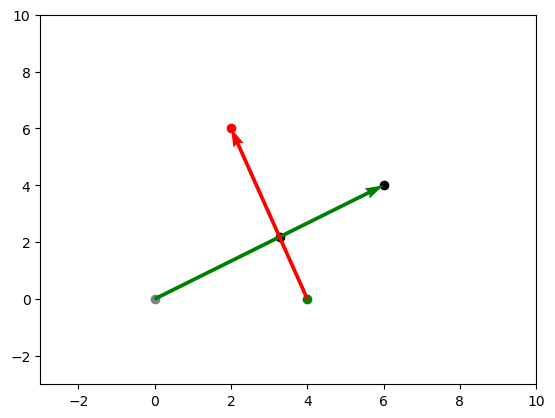

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
A = np.array([4,0])
B = np.array([2,6])
C = np.array([6,4])
D = np.array([0,0])

plt.xlim(-3,10)
plt.ylim(-3,10)
plt.scatter(D[0],D[1], color= 'grey')
plt.scatter(A[0],A[1],color='green')
plt.scatter(B[0], B[1], color='red')
plt.scatter(C[0],C[1],color = 'black')
# plt.scatter(3.2727, 1.1818,color = 'yellow')
plt.scatter( 3.272727272727273, 2.1818181818181817, color='black')
plt.quiver(0, 0, 6,4, angles = "xy", scale_units = "xy", scale = 1, color = 'green')
plt.quiver(A[0], A[1],-2, 6, angles = "xy", scale_units = "xy", scale = 1, color = 'red')
# plt.quiver(0,0,C[0], C[1], angles = "xy", scale_units = "xy", scale = 1, color = 'blue')

plt.show()

In [83]:
A = list(A)
B= list(B)
C = list(C)
D = list(D)
print(A,B,C,D)

pos_slope = (B[1] - A[1])/(B[0] - A[0])
pos_const = A[1] - pos_slope * A[0]

signal_slope = (C[1] - D[1])/(C[0] - D[0])
signal_const = D[0] - signal_slope * D[0]

x_intersept = (signal_const - pos_const)/(pos_slope - signal_slope)
y_intersept = pos_slope * x_intersept + pos_const
print(f'X = {x_intersept} Y = {y_intersept}')
a1,b1,c1 = pos_slope, A[1], pos_const 
a2,b2,c2 =  signal_slope, B[1], signal_const

S = np.array([[a1, b1], [a2, b2]])
b = np.array([-c1, -c2])

print(pos_slope)
print(pos_const)
print(np.linalg.solve(S,b))
print(B[1] == pos_slope * B[0] + pos_const)

[4, 0] [2, 6] [6, 4] [0, 0]
X = 3.272727272727273 Y = 2.1818181818181817
-3.0
12.0
[ 4.         -0.44444444]
True
